# Energy Star Score Prediction
- A "take-home" data project.
- The objective of this problem is to predict the the energy-star score of buildings.

## Workflow
1. Data cleaning and processing (handle outliers and missing values)
2. Exploratory analysis
3. Feature engineering and feature selction
4. Split data into test/train set and establish a baseline prediction. 
5. Model evaluation and selection: compare several models (with each other and wrt baseline) based on a performance metric. Use resampling methods such as k-fold CV to estimated the test error.
7. Select the "best" model and tune its hyperparameters. 
8. Evaluate the final "optimized" model on the test set.
9. Interpret the results.

In [60]:
'''data'''
import pandas as pd
import numpy as np
import pprint

'''plots'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


'''processing'''
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

'''model selection'''
from sklearn.model_selection import train_test_split, cross_validate

'''metrics'''
from sklearn.metrics import mean_squared_error

'''ML methods'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

'''Hyperparameter'''
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

'''debugger'''
from IPython.core.debugger import set_trace

## Import

In [4]:
# Read the data
df = pd.read_csv("data/full_data.csv")

In [5]:
df.head(3)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,...,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,...,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...


In [6]:
df.shape

(11746, 60)

**Thoughts:**
- I have 59 features and one response varaible (Energy Star Score).
- Just over 10K observations, sample size is relatively small.
- Just based on the names, I actually don't know that much about the features-- will mainly rely on exploratory analysis to decide which of these are informative in predicting Energy Start Score.

**Energy Star Score**
- Response Varaible is ENERGY STAR SCORE:  It is percentile ranking [1,100] for specific building types. 
- It is computed based on "self-reported" energy usage for a year.
- 1 means the building has very low energy efficiency, and 1 means it has high efficiecny.  "Percentile rank" means it is a relative measure  (I expect a uniform distribution for this reason).
- A "self-report" metric might not be a good metric: are there any alternatives?

## Data type

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11746 non-null  object 
 7   NYC Building Identification Number (BIN)                    11746 non-null  object 
 

**Thoughts:**
- Most variables are "object", even varaibles that I expect to be numeric (ex: water use).  That means missing values are labelled with a string like "unknown" or "not available".
- However, for float variables like latitude and longitude, the missing values are coded as np.nan since we see around 1000 missing values.

In [8]:
df.isnull().sum().sort_values(ascending=False)

NTA                                                           2263
Longitude                                                     2263
Census Tract                                                  2263
Council District                                              2263
Community Board                                               2263
Latitude                                                      2263
Street Number                                                  124
Street Name                                                    122
Water Required?                                                118
Borough                                                        118
DOF Gross Floor Area                                           118
DOF Benchmarking Submission Status                              30
BBL - 10 digits                                                 11
Fuel Oil #2 Use (kBtu)                                           0
Weather Normalized Site Electricity (kWh)                     

In [9]:
df["Natural Gas Use (kBtu)"].head(5)  # Missing values are labelled "Not Available"

0    Not Available
1        933073441
2    Not Available
3    Not Available
4    Not Available
Name: Natural Gas Use (kBtu), dtype: object

In [10]:
# Replace all "Not Available" with np.nan
df = df.replace({'Not Available':np.nan})

In [11]:
# Check out "Natural Gas Use" again
df.loc[:5,"Natural Gas Use (kBtu)"]

0               NaN
1         933073441
2               NaN
3               NaN
4               NaN
5    1.4322508769E9
Name: Natural Gas Use (kBtu), dtype: object

**After replacing the "Not Available" with np.nan (floats), we need to convert all numeric columns into numeric datatypes.  To determine which variables are numeric, one clue is to look at whether the variable has units (ex: kBtu)**


In [12]:
df.filter(regex='ft²|kBtu/ft²|kWh/ft²|therms/ft²|kBtu|therms|kWh|Metric Tons CO2e|kgal|gal/ft²|Score').columns

Index(['Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)',
       'ENERGY STAR Score', 'Site EUI (kBtu/ft²)',
       'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)', 'Fuel Oil #1 Use (kBtu)',
       'Fuel Oil #2 Use (kBtu)', 'Fuel Oil #4 Use (kBtu)',
       'Fuel Oil #5 & 6 Use (kBtu)', 'Diesel #2 Use (kBtu)',
       'District Steam Use (kBtu)', 'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
       'P

In [13]:
col_convert=list(df.filter(regex='ft²|kBtu/ft²|kWh/ft²|therms/ft²|kBtu|therms|kWh|Metric Tons CO2e|kgal|gal/ft²|Score').columns)

In [14]:
# Convert column names with "units" to float
df[col_convert] = df[col_convert].astype(float)

In [15]:
# Take a look at the descriptive statistics for each numeric column
df.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,...,Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,...,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,...,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,...,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,...,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,...,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,...,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,...,4.249000e+02,1.584140e+05,8.031875e+03,70.805000,162.750000,40.817623,-73.932443,9.000000,33.000000,531.500000
max,14993.000000,5.991312e+06,1.354011e+07,1.421712e+07,962428.000000,591640.000000,2019.000000,161.000000,100.000000,100.000000,...,4.764375e+06,1.421712e+07,6.594604e+06,96305.690000,912801.100000,40.912869,-73.715543,56.000000,51.000000,155101.000000


**Let's look at the categorical variables**

In [16]:
df.dtypes[df.dtypes=="O"]

Property Name                                     object
Parent Property Id                                object
Parent Property Name                              object
BBL - 10 digits                                   object
NYC Borough, Block and Lot (BBL) self-reported    object
NYC Building Identification Number (BIN)          object
Address 1 (self-reported)                         object
Address 2                                         object
Postal Code                                       object
Street Number                                     object
Street Name                                       object
Borough                                           object
Primary Property Type - Self Selected             object
List of All Property Use Types at Property        object
Largest Property Use Type                         object
2nd Largest Property Use Type                     object
3rd Largest Property Use Type                     object
Metered Areas (Energy)         

**Thoughts**
- Of all the above categorical features, most of them doesn't seem to be that relevant to Energy efficiency of buildings.
- The only exception is maybe "Largest Property Use Type"?
- I will explore "Largest Propery Use Type" in more detail.  I will probably not include the rest of the categorical variables in our models.

## Missing Values
- Let's check out the percent missing values for each column.

This function takes a DataFrame and return a DataFrame with two columns: 
    - Total count missing values
    - Total missing value percentage


In [17]:
def missing_val(df):
    total= df.isnull().sum().sort_values(ascending=False)  
    percent = round((total/len(df))*100,2)
    
    return pd.concat([total,percent], axis=1, keys=['count', 'percent'])

In [18]:
missing_val(df).head()  # Top 10 variables with missing values

,count,percent
Fuel Oil #1 Use (kBtu),11737,99.92
Diesel #2 Use (kBtu),11730,99.86
Address 2,11539,98.24
Fuel Oil #5 & 6 Use (kBtu),11152,94.94
District Steam Use (kBtu),10810,92.03


### Thoughts:
- Some variables has a very high percentage of missing values.
- We probably want to remove features that have greater than 50% missing values as they won't be that useful for our models.

In [19]:
temp1 = missing_val(df)
temp2 = temp1[temp1["percent"]>50]

In [20]:
# Drop columns with more than 50% missing
df.drop(list(temp2.index), axis=1, inplace=True)

In [21]:
df.shape # Now we are down to 49 variables (48 features)

(11746, 49)

In [22]:
# Check out the top 10 variables with missing values again
missing_val(df).head()  # Top 10 variables with missing values

,count,percent
Metered Areas (Water),4609,39.24
Water Use (All Water Sources) (kgal),3984,33.92
Water Intensity (All Water Sources) (gal/ft²),3984,33.92
Longitude,2263,19.27
Latitude,2263,19.27


## Exploratory Data Analysis
- Make plots & examine summary statistics to understand the data better.
- Are there any patterns, anomalies, relationships?
- What are the correlation between the features and the response variables. I should choose variables that are highly correlated with the response variable and have high variance to be in our model.
- I started with a high level overview, then drill down to specific variables of the dataset.

**Let's start with the response (univariate analysis)**

In [23]:
# rename Energy Star Score to "score"
df.rename(columns = {"ENERGY STAR Score":"score"}, inplace=True)

/Users/hfung/.pyenv/versions/practice_projects/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of score')

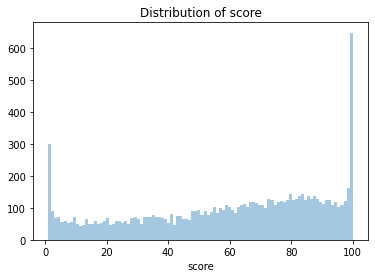

In [24]:
# Plot histogram to look at the probability distribution of "score" (I expect a uniform distribution)
fig = plt.figure(figsize=(6,4))
sns.distplot(df.score.dropna(), bins=100, hist=True, kde=False)
plt.title("Distribution of score")

### Thoughts:
- The two most common scores are 0 and 100.  
- Why are there so many 100s, maybe because owners inflate their self-reported energy score?
- Is it possible to have 0, why are there so many of the,?
- How does this self-reported score compare to another metric called Energy Use Intensity (EUI).  It is a ratio of total energy use and sq-ft of the building.
- I expect EUI to have normal distribution (since it is not a percentile rank).

Text(0.5, 1.0, 'Distribution of Site EUI (kBtu/ft²)')

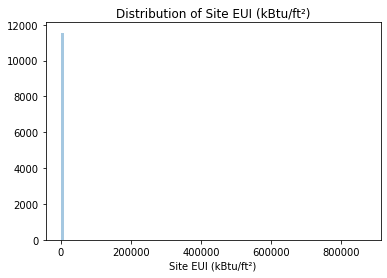

In [25]:
fig = plt.figure(figsize=(6,4))
sns.distplot(df["Site EUI (kBtu/ft²)"].dropna(), bins=100, hist=True, kde=False)
plt.title("Distribution of Site EUI (kBtu/ft²)")

**Some buildings have a very high score (outliers)!**

In [26]:
df["Site EUI (kBtu/ft²)"].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [27]:
# The top 10 scores are:
df["Site EUI (kBtu/ft²)"].dropna().sort_values(ascending=False).head(10)

8068    869265.0
7       143974.4
3898    126307.4
8174    112173.6
8268    103562.7
3263     95560.2
8269     84969.6
3383     78360.1
3170     51831.2
3173     51328.8
Name: Site EUI (kBtu/ft²), dtype: float64

In [28]:
# The building (index 8068) is 8X higher than the second highest building, let's check it out.
df.iloc[8068,:]

Order                                                                                                      9984
Property Id                                                                                             4414323
Property Name                                                                                      234 Skillman
Parent Property Id                                                          Not Applicable: Standalone Property
Parent Property Name                                                        Not Applicable: Standalone Property
BBL - 10 digits                                                                                      3028937502
NYC Borough, Block and Lot (BBL) self-reported                                                       3028937502
NYC Building Identification Number (BIN)                                                      3390250 , 3338313
Address 1 (self-reported)                                                                   234 Skillman

### Thoughts
- I don't notice anything particular about this buildng.  Based on my understanding of the variables, I can't really tell why an outlier occurs and whether an outlier is natural or not.
- So, to be conservative, I will remove outliers that are below Q1-3*IQR and above Q3+3*IQR

In [29]:
# Calculate first and third quartile
q1 = df['Site EUI (kBtu/ft²)'].describe()["25%"]
q3 = df['Site EUI (kBtu/ft²)'].describe()["75%"]

In [30]:
# IQR
iqr = q3 - q1
lwr = q1 - 3*iqr
upr = q3 + 3*iqr

In [31]:
# Remove outliers (only keep observations within IQR)
df = df[(df['Site EUI (kBtu/ft²)']<upr) & (df['Site EUI (kBtu/ft²)']>lwr)]

/Users/hfung/.pyenv/versions/practice_projects/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Site EUI (kBtu/ft²)')

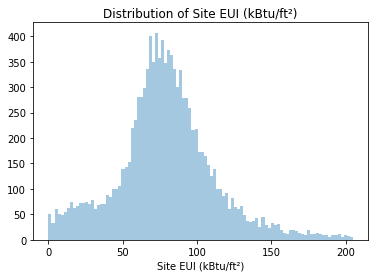

In [32]:
# Now look at distribution of EUI again
fig = plt.figure(figsize=(6,4))
sns.distplot(df["Site EUI (kBtu/ft²)"].dropna(), bins=100, hist=True, kde=False)
plt.title("Distribution of Site EUI (kBtu/ft²)")

### Thoughts
- With the outliers removed, sure enough, the distribution of EUI looks more like a normal distribution (but slightly right skewed)
- Although our objective is to predict the self-report score, I think we should instead predict EUI.  I can make a note of that in my conclusions.

## Bivariate Analysis
- Look for relationship between largest property use type and score
- Easy way would be to look at the average score for each level of the factor variables
- Another way is to look at the pdf of score at different levels of the factor variable
- Or boxplots (y axis= score, x axis = levels of the factor variable)
- In addition, I can use logistic regression to look at relationship between bourough and score

**"Largest Property Use Type"  (categorical variable)**

In [33]:
# drop all rows with score = NA
temp = df.dropna(subset=["score"])

In [34]:
temp["Largest Property Use Type"].value_counts()

Multifamily Housing                      7464
Office                                   1157
Hotel                                     202
Non-Refrigerated Warehouse                156
K-12 School                                97
Residence Hall/Dormitory                   96
Senior Care Community                      85
Distribution Center                        61
Retail Store                               57
Medical Office                             23
Hospital (General Medical & Surgical)      15
Financial Office                           12
Supermarket/Grocery Store                  10
Worship Facility                            9
Refrigerated Warehouse                      8
Parking                                     3
Wholesale Club/Supercenter                  3
Courthouse                                  2
Bank Branch                                 1
Name: Largest Property Use Type, dtype: int64

### Thoughts:
- Imbalance classes, I should ignore classes with less than 100 observations.

In [35]:
# Create a list of levels with more than 100 measurements
temp1 =temp['Largest Property Use Type'].value_counts()

In [36]:
temp2=temp1[temp1>100]

In [37]:
# We will only analyse these types of observations
temp2=list(temp2.index)
temp2

['Multifamily Housing', 'Office', 'Hotel', 'Non-Refrigerated Warehouse']

In [38]:
subset = df[df['Largest Property Use Type'].isin(temp2)]

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Multifamily Housing'),
  Text(1, 0, 'Office'),
  Text(2, 0, 'Hotel'),
  Text(3, 0, 'Non-Refrigerated Warehouse')])

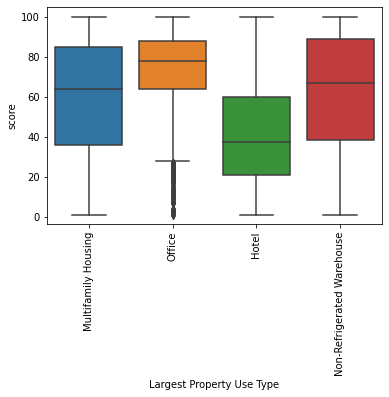

In [39]:
fig = plt.figure(figsize=(6,4)) 
sns.boxplot(y="score", x="Largest Property Use Type", data=subset) 
plt.xticks(rotation=90)

Text(0.5, 0, 'score')

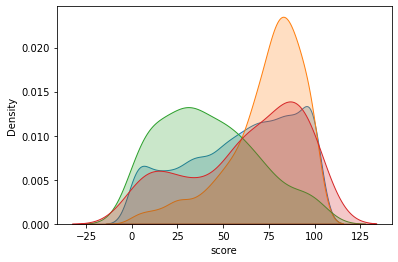

In [40]:
# I can plot pdf of scores by "Largest Property Use Type"
fig = plt.figure(figsize=(6,4))
for i, name in enumerate(temp2):
    sns.kdeplot(data=subset.loc[subset["Largest Property Use Type"]==name, "score"], 
            shade=True,
            label=name)
    
plt.xlabel("score")

**Thoughts**
- Hotel has the lowest average score, variance is small also.
- Office has the highest average score, lowest variance, but lots of outliers (which make sense, firms vary in values/cultures)
- Family house and warehouse is similar in terms of score and distribtion: they both have higher variation.

In [41]:
subset=subset[["score","Largest Property Use Type"]]
subset.dropna(inplace=True)
y=subset["score"]
X=pd.get_dummies(subset["Largest Property Use Type"], drop_first=True)

In [42]:
import statsmodels.api as sm
X = sm.add_constant(X) # add a column of 1s
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sun, 28 Aug 2022   Prob (F-statistic):           2.70e-69
Time:                        15:09:54   Log-Likelihood:                -42930.
No. Observations:                8979   AIC:                         8.587e+04
Df Residuals:                    8975   BIC:                         8.590e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

**The small $R_{adj}^2$ suggests that this feature doesn't have strong relationships with score.**

**Correlations between continuous features and the response variable**
    - Usually I use Spearman correlation so that I don't have to assume the variables are normally distributed and they are linearly correlated with each other.

In [43]:
# Find all spearman correlations and sort 
correlations_data = df.corr(method='spearman')
# Let's first just look at correlation between each feature and score
correlations_data=correlations_data["score"]
# Sort the correlation and find out the top 10 most positively correlated, and top 10 most negatively correlated
correlations_data = correlations_data.sort_values(ascending=False)

In [44]:
correlations_data.head(10)

score                                                 1.000000
Community Board                                       0.051750
Council District                                      0.047002
Largest Property Use Type - Gross Floor Area (ft²)    0.040009
Property GFA - Self-Reported (ft²)                    0.035248
Order                                                 0.024251
Census Tract                                          0.018835
DOF Gross Floor Area                                 -0.001760
Number of Buildings - Self-reported                  -0.016234
Occupancy                                            -0.017486
Name: score, dtype: float64

In [45]:
correlations_data.tail(10)

Electricity Use - Grid Purchase (kBtu)                       -0.289813
Indirect GHG Emissions (Metric Tons CO2e)                    -0.295726
Direct GHG Emissions (Metric Tons CO2e)                      -0.340328
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346797
Total GHG Emissions (Metric Tons CO2e)                       -0.410226
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.450946
Weather Normalized Site EUI (kBtu/ft²)                       -0.744765
Weather Normalized Source EUI (kBtu/ft²)                     -0.752733
Source EUI (kBtu/ft²)                                        -0.755069
Site EUI (kBtu/ft²)                                          -0.759466
Name: score, dtype: float64

**Thoughts**
- The most strongly negative correlations are EUI (different flavours of it), Electricity and GHG emissions.
- A high EUI means building is less efficent so score should be lower.
- Most positive correlations are very small.

**Correlations between log(features) and response**
- In case there is nonlinear relationships between IV and DV, I can log all numerical IVs, and then find correlation between log(IV) and DV
- I can also check sqrt(IV) and DV for skewed data

In [46]:
# Select only numeric data
numeric_col = list(df.dtypes[df.dtypes !="object"].index)
numeric_subset = df[numeric_col]

In [47]:
# Generate extra sqrt_XXX and log_XXXX transformed columns for all features 
for col in numeric_subset.columns.values:
    if col !="score": # exclude the response variable
        numeric_subset["log_"+col] = np.log(numeric_subset[col])
        numeric_subset["sqrt_"+col] = np.sqrt(numeric_subset[col])

/var/folders/0t/47qwfn79375230vlpg79zkdh0000gn/T/ipykernel_7515/762950910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset["log_"+col] = np.log(numeric_subset[col])
/var/folders/0t/47qwfn79375230vlpg79zkdh0000gn/T/ipykernel_7515/762950910.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset["sqrt_"+col] = np.sqrt(numeric_subset[col])
/var/folders/0t/47qwfn79375230vlpg79zkdh0000gn/T/ipykernel_7515/762950910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [48]:
numeric_subset.sample(3)

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),...,log_Latitude,sqrt_Latitude,log_Longitude,sqrt_Longitude,log_Community Board,sqrt_Community Board,log_Council District,sqrt_Council District,log_Census Tract,sqrt_Census Tract
1783,2107,4924102,72984.0,72994.0,1930,1,100,96.0,38.0,38.0,...,3.707467,6.383610,NaN,NaN,1.609438,2.236068,1.386294,2.000000,4.430817,9.165151
9370,11706,4406055,61000.0,60992.0,1938,1,100,100.0,13.4,13.4,...,3.703445,6.370783,NaN,NaN,2.708050,3.872983,3.871201,6.928203,6.396930,24.494897
10035,12609,2615609,399204.0,401868.0,1952,1,100,57.0,86.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Find all correlations and sort 
correlations_data=numeric_subset.corr(method='spearman')["score"]
# Let's sort the correlation and find out the top 10 most positively correlated, and top 10 most negatively correlated
correlations_data = correlations_data.sort_values(ascending=False)

In [50]:
correlations_data.head(10)

score                                                      1.000000
Community Board                                            0.051750
sqrt_Community Board                                       0.051750
log_Community Board                                        0.051750
Council District                                           0.047002
sqrt_Council District                                      0.047002
log_Council District                                       0.047002
sqrt_Largest Property Use Type - Gross Floor Area (ft²)    0.040009
Largest Property Use Type - Gross Floor Area (ft²)         0.040009
log_Largest Property Use Type - Gross Floor Area (ft²)     0.040009
Name: score, dtype: float64

In [51]:
correlations_data.dropna().tail(15)

log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.447804
Weather Normalized Site Electricity Intensity (kWh/ft²)        -0.450946
sqrt_Weather Normalized Site Electricity Intensity (kWh/ft²)   -0.450946
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.744144
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.744765
Weather Normalized Site EUI (kBtu/ft²)                         -0.744765
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.752128
Weather Normalized Source EUI (kBtu/ft²)                       -0.752733
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.752733
log_Source EUI (kBtu/ft²)                                      -0.754464
sqrt_Source EUI (kBtu/ft²)                                     -0.755069
Source EUI (kBtu/ft²)                                          -0.755069
log_Site EUI (kBtu/ft²)                                        -0.758877
sqrt_Site EUI (kBtu/ft²)                           

**Thoughts**
- I transformed all numeric variables with log and sqrt
- EUI and Energy Intensity remain the most negatively correlated features with DV.  The log and sqrt variables for EUI and Energy are pretty close to their non-transformed counterparts. Perhaps the transformed variables are not needed 

In [52]:
# Keep only the continuous variables, and drop all rows where "score" is missing
data = numeric_subset
data.dropna(subset=["score"], inplace=True)  

## Bivariate Analysis (Visualization)
- From the correlation, I now know the most important features (ex: EUI).
- I can try to plot some of these "important features" against score
- Since there are many features, it is very time consuming for us to look at scatterplot between all IV and DV (in a matrix for example).  Thus, by picking only the most relevant IVs, it will reduce the size of our scatterplot matrix a bit and avoid information overload.

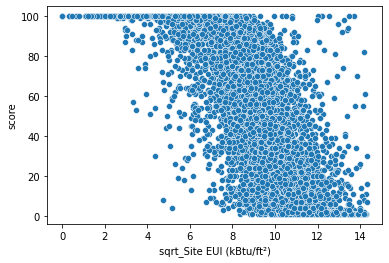

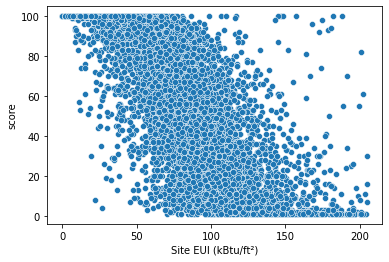

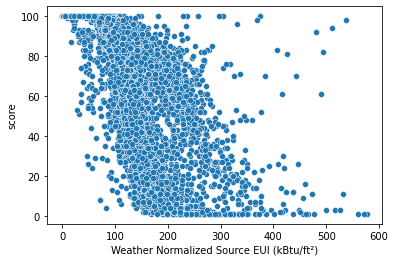

In [53]:
# Scatter plot of EUI (x axis) vs score (y-axis)
for var in ["sqrt_Site EUI (kBtu/ft²)","Site EUI (kBtu/ft²)","Weather Normalized Source EUI (kBtu/ft²)"]:
    fig = plt.figure (figsize=(6,4))
    sns.scatterplot(x=var, y="score", data=data)

### Thoughts
- There is a clear negative (linear) relationship between these features and the score. Perhaps the log and sqrt variables are not necessary.

## Pair Grid
- A matrix of scatter plots to see relationships between IVs and between IV and DV
- We will only plot a subset of variables of interest in the features df

In [54]:
# Extract the columns to  plot
plot_data = data[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]
# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

In [55]:
# Rename columns 
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emission'})

In [56]:
# Drop na values
plot_data = plot_data.dropna()

/Users/hfung/.pyenv/versions/practice_projects/lib/python3.9/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


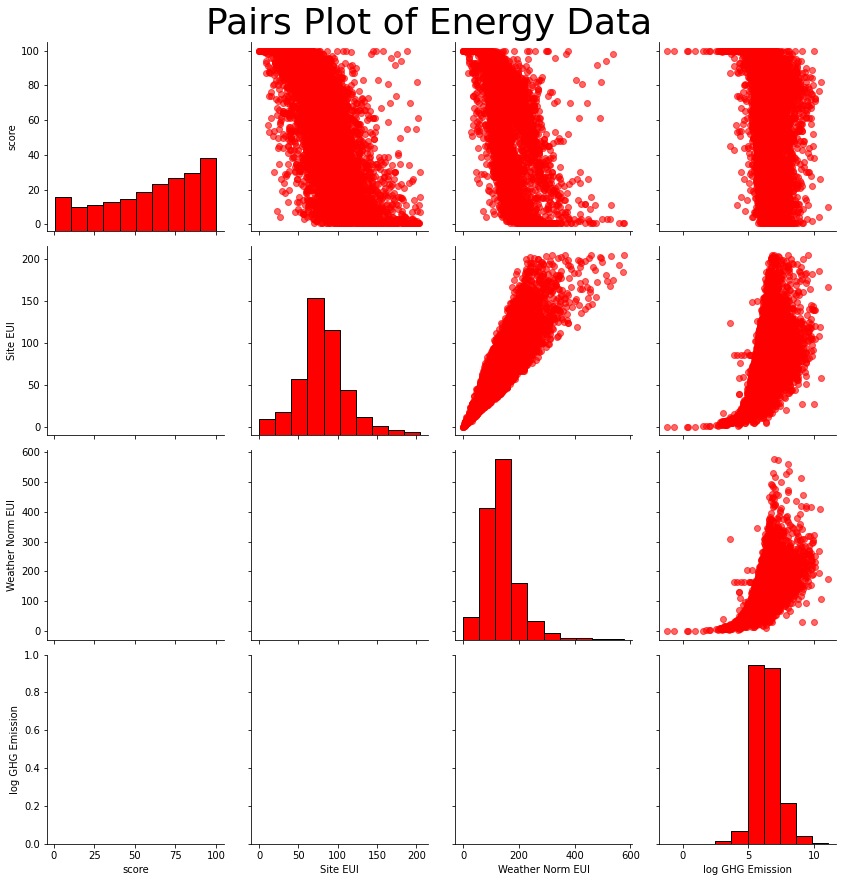

In [57]:
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)
# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)
# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')
# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

## Feature Engineering and Selection
- Feature Engineering: Use results of exploratory to generate additional features that affect the response. For example:
    - Doing log and sqrt transformation to numerical features
    - One hot encode categorical features
- Feature selection: Need to also select the most relevant feature to include in our model:
    - Select features based on its correlation with the response
    - Selecting features with the most variance (low variance features will lead to higher error variance)
    - Often we have to do modelling first (ex RF), and then identify the most important features, and then re-run model with a smaller subset of features. So it is an iterative process. 
    - Feature engineering and selection often has the highest returns on time invested in a machine learning problem. It can take quite a while to get right, but is often more important than the exact algorithm and hyperparameters used for the model.

**Facts from exploratory analysis:**
- Categorical features doesn't seem to be related to response, so we will exclude them from the model.
- Taking the log transformation of features does not result in significant increases in the linear correlations between features and the score. So log transformation is not that useful in this problem.

## Remove Collinear Features
- Highly collinear features have a significant correlation coefficent between them. For example, in our dataset, the Site EUI and Weather Norm EUI are highly correlated because they are just slightly different means of calculating the energy use intensity.
- There are a number of methods for removing collinear features, such as using the Variance Inflation Factor. We will use a simpler metric, and remove features that have a correlation coefficient above a certain threshold with each other.
- We have X and log(X) as our features.  Since X and log(X) are highly collinear, one of them will be removed.

**The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value.**

In [115]:
from typing import Union
from typing import List, Dict

num_type = Union[int, float, complex]
def remove_collinear_features(
    df: pd.DataFrame,
    DV: str,
    threshold: num_type,
    drop_collinear: bool = True,
    print_collinear: bool = False,
    custom_drop: List[str] = [],
) -> pd.DataFrame:
    """
    remove_collinear_features:

    There are a number of methods for removing collinear features, such as using the
    Variance Inflation Factor. Here, We will use a simpler metric, and remove features
    that have a correlation coefficient above a certain threshold with each other.

    This function removes the collinear continuous features based on a threshold we select for the
    correlation coefficients by removing one of the two features that are compared. It also prints
    the correlations that it removes so we can see the effect of adjusting the threshold.
    We will use a threshold of 0.6 which removes one of a pair of features if the correlation
    coefficient between the features exceeds this value.

    Args:
        df (pd.DataFrame): input dataframe
        DV (str): dependent variable
        threshold (numeric): threshold of correlation above which we will drop one of the variable
        drop_collinear(bool): drop one of the collinear variables if True, otherwise return the original df
        print_collinear (bool): print collinear pairs
        custom_drop (bool): custom list of variables to drop from the dataframe in addition to the collinear ones
    Returns:
        df_out (pd.DataFrame): output dataframe
        df_collinear_pairs (pd.DataFrame): a dataframe of collinear pairs and their correlation
    """
    # make a copy of the input dataframe
    data = df.copy()

    # save the dependent variable
    y = data[DV]
    # handle features only
    df_out = data.drop(columns=[DV])

    # Calculate the correlation matrix
    corr_matrix = df_out.corr()
    iters = range(len(corr_matrix.columns) - 1)
    # Init a list of columns to be dropped
    drop_cols = []
    # Init a list of tuples that contains 1) collinear col_1,
    # 2) collinear col_2, and 3) correlation between them
    collinear_pairs = []

    # Iterate through the correlation matrix and compare correlations
    # If I have k features, corr_matrix has shape (kxk)
    for i in iters:  # iterate from 0 to k-1
        for j in range(i):  # iterate from 0 to k-1
            item = corr_matrix.iloc[j : (j + 1), (i + 1) : (i + 2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:

                # Print the correlated features and the correlation value
                if print_collinear:
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))

                # Add the tuple of collinear pairs and their correlation to a list
                collinear_pairs.append(
                    (col.values[0], row.values[0], round(val[0][0], 2))
                )
                # Add one of the variable to the "drop_cols" list
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    if drop_collinear:
        df_out = df_out.drop(columns=drops)

    # Drop additional columns that are specified by the using
    if custom_drop != []:
        df_out = df_out.drop(columns=custom_drop)

    # Add the score back in to the data
    df_out[DV] = y

    # Convert collinear_pairs to a dataframe
    df_collinear_pairs = pd.DataFrame(
        collinear_pairs, columns=["var_1", "var_2", "correlation"]
    )

    # Drop duplicated rows in terms of var_1 and var_2 (order does not matter)
    # False if row is a duplicated that needs to be removed
    mask = ~pd.DataFrame(
        np.sort(df_collinear_pairs[["var_1", "var_2"]], axis=1)
    ).duplicated()
    df_collinear_pairs = df_collinear_pairs[mask]

    return df_out, df_collinear_pairs

In [116]:
# Remove any columns with all nan values
data  = data.dropna(axis=1, how = 'all')
data.shape

(9461, 83)

In [117]:
additional_drops =['Weather Normalized Site EUI (kBtu/ft²)', 
                    'Water Use (All Water Sources) (kgal)',
                    'log_Water Use (All Water Sources) (kgal)']

In [126]:
processed, df_collinear_pairs= remove_collinear_features(
    df = data,
    DV = "score",
    threshold = 0.6,
    drop_collinear = True,
    print_collinear= True,
    custom_drop = additional_drops
) 

Weather Normalized Source EUI (kBtu/ft²) | Site EUI (kBtu/ft²) | 0.81
Weather Normalized Source EUI (kBtu/ft²) | Weather Normalized Site EUI (kBtu/ft²) | 0.79
Weather Normalized Source EUI (kBtu/ft²) | Weather Normalized Site Electricity Intensity (kWh/ft²) | 0.84
Electricity Use - Grid Purchase (kBtu) | DOF Gross Floor Area | 0.66
Electricity Use - Grid Purchase (kBtu) | Largest Property Use Type - Gross Floor Area (ft²) | 0.67
Weather Normalized Site Electricity (kWh) | DOF Gross Floor Area | 0.68
Weather Normalized Site Electricity (kWh) | Largest Property Use Type - Gross Floor Area (ft²) | 0.67
Total GHG Emissions (Metric Tons CO2e) | DOF Gross Floor Area | 0.8
Total GHG Emissions (Metric Tons CO2e) | Largest Property Use Type - Gross Floor Area (ft²) | 0.82
Total GHG Emissions (Metric Tons CO2e) | Natural Gas Use (kBtu) | 0.66
Total GHG Emissions (Metric Tons CO2e) | Weather Normalized Site Natural Gas Use (therms) | 0.65
Total GHG Emissions (Metric Tons CO2e) | Electricity Use -

In [127]:
processed.shape

(9461, 19)

In [120]:
df_collinear_pairs

,var_1,var_2,correlation
0,Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),0.81
1,Weather Normalized Source EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),0.79
2,Weather Normalized Source EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity ...,0.84
3,Electricity Use - Grid Purchase (kBtu),DOF Gross Floor Area,0.66
4,Electricity Use - Grid Purchase (kBtu),Largest Property Use Type - Gross Floor Area (...,0.67
...,...,...,...
340,sqrt_Council District,Council District,0.99
341,sqrt_Council District,log_Order,0.71
342,sqrt_Council District,sqrt_Order,0.85
343,log_Census Tract,Census Tract,0.79


**Thoughts**
- Our final dataset now has 19 features (one of the columns is the response).  This is a much smaller set of features (compared to before where we have 83 features).  
- Models such as the random forest perform implicit feature selection and automatically determine which features are important during traning.

## Split Into Training and Testing Set

In [178]:
# Separate out the features and DV
X = processed.drop(columns='score')
y = pd.DataFrame(processed['score'])

In [179]:
# Replace the inf and -inf with nan (required for later missing value imputation)
X = X.replace({np.inf: np.nan, -np.inf: np.nan})

In [180]:
# Split into 70% training and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [181]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6622, 18), (2839, 18), (6622, 1), (2839, 1))

## Baseline Prediction
- Establish a "naive" baseline prediction before we start making machine learning models. 
- If the models we build cannot outperform a naive guess then we have to admit that machine learning is not suited for this problem. 
- Maybe because we need more data, or because there is a simpler solution that does not require machine learning. 

### Metric: root mean square error (SER, or RMSE)
- I always use a single real-value performance metric in order to compare models because it simplifies the evaluate process. Rather than calculating multiple metrics and trying to determine how important each one is, we should use a single number. In this case, because we have a regression problem, I will use SER (RMSE).

In [182]:
# Function to calculate rmse
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.array(y_true-y_pred)**2))

**Our "naive" prediction of the score is the median score in the full sample (that's my y_pred regardless of the values of the features)**

In [183]:
baseline_guess = np.median(y)

In [184]:
print("The baseline guess is a score of {}".format(baseline_guess))

The baseline guess is a score of 66.0


In [185]:
print("Baseline Performance on the test set: RMSE = {}".format(round(rmse(y_test, baseline_guess),4)))

Baseline Performance on the test set: RMSE = 29.6683


**The typical gap between true y and predicted y is 29.66  (close to 30% error since score can only take on values between 1-100!**

## Handling Missing Values

- Many machine learning models cannot deal with missing values. 
- Thus, I have to find a way to fill in missing values or disard any features with a lot of missing values. 
- Since we already removed features with more than 50% missing values, here we will focus on filling in these missing values (a process known as imputation). 
- There are a number of methods for imputation but here we will use the relatively simple method of replacing missing values with the median of the column.  I can generally use this method if the variable has less than 10% missing value.

In [186]:
missing_val(processed).head(10)  # Top 10 variables with missing values

,count,percent
Water Intensity (All Water Sources) (gal/ft²),3034,32.07
Census Tract,1799,19.01
Community Board,1799,19.01
Longitude,1799,19.01
Latitude,1799,19.01
Weather Normalized Site Natural Gas Intensity (therms/ft²),1381,14.60
Weather Normalized Site Natural Gas Use (therms),1381,14.60
Natural Gas Use (kBtu),982,10.38
Weather Normalized Site Electricity Intensity (kWh/ft²),475,5.02
DOF Gross Floor Area,48,0.51


**Thoughts**
- Of the features that have missing value of over 10%, only one variables are on the top 10 list of highly correlated features with the response variable:
    - Weather Normalized Site Natural Gas Intensity (therms/ft²)	14.60

- For this reason, except for this variable, all other variables will be imputed with column median.  I will use a modelling approach to impute "Weather Normalized Site Natural Gas Intensity (therms/ft²)"

## Median Imputation
- We create a Scikit-learn Imputer object to fill in missing values with the median of the column. Notice that we train the imputer (using the Imputer.fit method) on the training data but not the testing data. We then transform (using Imputer.transform) both the training data and test data. This means that the missing values in the test set are filled in with the median value of the corresponding columns in the train set. This is done to avoid data leakage where information from the test dataset leaks into the training dataset.


In [187]:
# Init the imputer object (use median strategy)
imputer = SimpleImputer(strategy='median')

In [188]:
# Get dataset withinout "Weather Normalized Site Natural Gas Intensity (therms/ft²)"
X_train_temp = X_train.drop("Weather Normalized Site Natural Gas Intensity (therms/ft²)", axis=1)
X_test_temp = X_test.drop("Weather Normalized Site Natural Gas Intensity (therms/ft²)", axis=1)
# save column names
col_names_temp = X_train_temp.columns.values 

In [189]:
# Train imputer on the training features
imputer.fit(X_train_temp)

# Transform both the train dataset and the test dataset with the imputer
X_train_temp = imputer.transform(X_train_temp)
X_test_temp = imputer.transform(X_test_temp)

In [190]:
# build imputed DataFrames
X_train_temp = pd.DataFrame(X_train_temp, columns=col_names_temp)
X_test_temp = pd.DataFrame(X_test_temp, columns=col_names_temp)

In [191]:
# Put back the excluded variable
X_train_temp["Weather Normalized Site Natural Gas Intensity (therms/ft²)"] = X_train["Weather Normalized Site " + 
                                                                                     "Natural Gas Intensity (therms/ft²)"]

X_test_temp["Weather Normalized Site Natural Gas Intensity (therms/ft²)"] = X_test["Weather Normalized Site " + 
                                                                                     "Natural Gas Intensity (therms/ft²)"]

In [192]:
# Update X_train and X_test
X_train = X_train_temp
X_test  = X_test_temp

In [193]:
X_train.shape, X_test.shape

((6622, 18), (2839, 18))

### Use Random Forest to predict the missing of "Weather Normalized Site Natural Gas Intensity (therms/ft²)"

In [194]:
def rf_missing_val(df):

    # Split the df into two subsets.  We call the rows with gas intensity values as "temp_train", and rows
    # with missing gas intensity values as "temp_test" (we know this is around 30% of train dataset)
    temp_train = df[df["Weather Normalized Site Natural Gas Intensity (therms/ft²)"].notnull()]
    temp_test = df[df["Weather Normalized Site Natural Gas Intensity (therms/ft²)"].isnull()]
    
    # Get the features and the response variable
    X = temp_train.drop("Weather Normalized Site Natural Gas Intensity (therms/ft²)", axis=1) # features 
    y = temp_train["Weather Normalized Site Natural Gas Intensity (therms/ft²)"]  # response variable
     
    # Init the RF regressor model
    regr = RandomForestRegressor(n_estimators=100, n_jobs=-1) 
    # Train model
    regr.fit(X,y) 
    
    # Predict using the trained RF model
    y_pred = regr.predict(temp_test.drop("Weather Normalized Site Natural Gas Intensity (therms/ft²)", axis=1))
    
    # Impute the DataFrame with the predicted values
    df.loc[df["Weather Normalized Site Natural Gas Intensity (therms/ft²)"].isnull(), 
           "Weather Normalized Site Natural Gas Intensity (therms/ft²)"] = y_pred

In [195]:
rf_missing_val(X_train)
rf_missing_val(X_test)

In [196]:
print("The number of missing values in X_train is:\n{}".format(np.sum(np.isnan(X_train))))

The number of missing values in X_train is:
Order                                                         0
Property Id                                                   0
DOF Gross Floor Area                                          0
Largest Property Use Type - Gross Floor Area (ft²)            0
Year Built                                                    0
Number of Buildings - Self-reported                           0
Occupancy                                                     0
Site EUI (kBtu/ft²)                                           0
Weather Normalized Site Electricity Intensity (kWh/ft²)       0
Natural Gas Use (kBtu)                                        0
Weather Normalized Site Natural Gas Use (therms)              0
Water Intensity (All Water Sources) (gal/ft²)                 0
Latitude                                                      0
Longitude                                                     0
Community Board                                             

In [197]:
print("The number of missing values in X_test is:\n{}".format(np.sum(np.isnan(X_test))))

The number of missing values in X_test is:
Order                                                         0
Property Id                                                   0
DOF Gross Floor Area                                          0
Largest Property Use Type - Gross Floor Area (ft²)            0
Year Built                                                    0
Number of Buildings - Self-reported                           0
Occupancy                                                     0
Site EUI (kBtu/ft²)                                           0
Weather Normalized Site Electricity Intensity (kWh/ft²)       0
Natural Gas Use (kBtu)                                        0
Weather Normalized Site Natural Gas Use (therms)              0
Water Intensity (All Water Sources) (gal/ft²)                 0
Latitude                                                      0
Longitude                                                     0
Community Board                                              

In [198]:
# Make sure no infinite values
print(np.where(~np.isfinite(X_train)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Modelling
- Linear Regression
- SVM
- Random Forest Regressor
- AdaBoost Regressor

In [199]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

### Create some Pipelines

In [200]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('regr', Lasso())]) # pipeline for lasso (l1) linear regression

In [201]:
pipe_svm= Pipeline([('scl', StandardScaler()),
                    ('regr', svm.SVR())]) # pipeline for svm

In [202]:
pipe_rf= Pipeline([('scl', StandardScaler()),
                    ('regr', RandomForestRegressor(random_state=42))]) # pipeline for rf

In [203]:
pipe_ab= Pipeline([('scl', StandardScaler()),
                    ('regr', AdaBoostRegressor(random_state=42))]) # pipeline for adaboost

**Set the Grid search parameters**

In [204]:
params_lr = {'regr__alpha': np.linspace(0.01, 10, num=50)}

In [205]:
params_svm = {'regr__gamma': np.linspace(0.001, 10, num=80), 
                'regr__C': np.linspace(0.001, 10, num=80) }

In [206]:
params_rf = {'regr__n_estimators': [int(x) for x in np.linspace(10, 200, num = 10)], 
              'regr__max_depth':  [int(x) for x in np.linspace(1, 20, num = 10)],
              'regr__min_samples_leaf':[1,2,4],
              'regr__min_samples_split':[2,5,10]}

In [207]:
params_ab = {'regr__n_estimators':  [int(x) for x in np.linspace(10, 200, num = 10)], 
              'regr__learning_rate': np.linspace(0.001, 1, num=20)}

In [208]:
n_iter_search =20

In [209]:
rs_lr = RandomizedSearchCV(estimator=pipe_lr,
                     param_distributions=params_lr,
                     scoring='neg_mean_squared_error', # use SER^2 as scoring
                     n_iter = n_iter_search,
                     n_jobs = -1,
                     verbose = 2)

In [210]:
rs_svm = RandomizedSearchCV(estimator=pipe_svm,
                     param_distributions=params_svm,
                     scoring='neg_mean_squared_error', # use SER^2 as scoring
                     n_iter = n_iter_search,
                     n_jobs = -1)

In [211]:
rs_rf = RandomizedSearchCV(estimator=pipe_rf,
                     param_distributions=params_rf,
                     scoring='neg_mean_squared_error', # use SER^2 as scoring
                     n_iter = n_iter_search,
                     n_jobs = -1,
                     verbose = 2)

In [212]:
rs_ab = RandomizedSearchCV(estimator=pipe_ab,
                     param_distributions=params_ab,
                     scoring='neg_mean_squared_error', # use SER^2 as scoring
                     n_iter = n_iter_search,
                     n_jobs = -1,
                     verbose = 2)

In [213]:
# List of pipelines for iteration
grids = [rs_lr, rs_svm, rs_rf, rs_ab]
# Dictionary of pipelines and type of classifier for reference
grid_dict = {0: 'Lasso Regression', 1: 'SVR', 2:'Random Forest', 3:'Adaboost'}

In [221]:
# Train the random search models

print('Training RandomGridSearch...')

for i, rs in enumerate(grids):
    print("\nEstimator: {}".format(grid_dict[i])) # classifier name
    
    # fit grid search
    rs.fit(X_train, y_train)
    
    # Get best parameters
    print("Best parameters are: {}".format(rs.best_params_))
    
    # Best estimated test MSE score (CV)
    print("Best estimated test MSE (from CV): {}".format(rs.best_score_))
    
    y_pred = rs.best_estimator_.predict(X_test)
    print("RMSE of best estimator (on the test set) is:{}".format((round(np.sqrt(mean_squared_error(y_test,y_pred)),4))))

Training RandomGridSearch...

Estimator: Lasso Regression
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.3s finished


Best parameters are: {'regr__alpha': 0.21387755102040817}
Best estimated test MSE: -379.0545828947181
RMSE of best estimator is:19.6494

Estimator: SVR


C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters are: {'regr__C': 8.60773417721519, 'regr__gamma': 0.001}
Best estimated test MSE: -402.89859143058084
RMSE of best estimator is:19.714

Estimator: Random Forest
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished
C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Best parameters are: {'regr__max_depth': 17, 'regr__min_samples_split': 2, 'regr__n_estimators': 115, 'regr__min_samples_leaf': 2}
Best estimated test MSE: -248.28146956681215
RMSE of best estimator is:15.8534

Estimator: Adaboost
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   31.3s finished
C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters are: {'regr__learning_rate': 0.5793684210526315, 'regr__n_estimators': 10}
Best estimated test MSE: -334.285461322672
RMSE of best estimator is:18.3899


### Refine model with GridSearch CV (fine-tune hyperparameters)
- Will only focus on Random Forest and Adaboost as we get the best performance from these models in RandomGridSearch

In [233]:
pipe_rf= Pipeline([('scl', StandardScaler()),
                    ('regr', RandomForestRegressor(min_samples_split=2,min_samples_leaf=2,
                                                   random_state=42))]) # pipeline for rf

pipe_ab= Pipeline([('scl', StandardScaler()),
                    ('regr', AdaBoostRegressor(random_state=42))]) # pipeline for adaboost

In [234]:
params_rf = {'regr__n_estimators': [110,113,115,118,120,125], 
              'regr__max_depth':  [15,16,17,18,19]}

In [235]:
params_ab = {'regr__learning_rate': [0.52,0.55,0.57,0.58,0.6], 
              'regr__n_estimators':  [5,6,7,8,9,10,12,14]}

In [236]:
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=params_rf,
                     scoring='neg_mean_squared_error', # use SER^2 as scoring
                     cv=10,
                     n_jobs = -1,
                     verbose = 2)

In [237]:
gs_ab = GridSearchCV(estimator=pipe_ab,
                     param_grid=params_ab,
                     scoring='neg_mean_squared_error', # use SER^2 as scoring
                     cv=10,
                     n_jobs = -1,
                     verbose = 2)

In [238]:
# List of pipelines for iteration
grids = [gs_rf, gs_ab]

# Dictionary of pipelines and type of classifier for reference
grid_dict = {0: 'Random Forest', 1:'Adaboost'}

In [239]:
# Train the grid search models

print('Training...')

# init the "best" variables
best_rmse = 999
best_regr_index = 0
best_gs = ''

for i, gs in enumerate(grids):
    print("\nEstimator: {}".format(grid_dict[i])) # model name
    
    # fit grid search
    gs.fit(X_train, y_train)
    
     # Get best parameters
    print("Best parameters are: {}".format(gs.best_params_))
    
    # Best estimated test error (CV)
    print("Best estimated test error (fron CV): {}".format(gs.best_score_))
    
    # test predictions 
    y_pred = gs.predict(X_test)
    
    print("RMSE for model with best parameters (on the test dataset): {}".format((round(np.sqrt(mean_squared_error(y_test,y_pred)),4))))
    
    if np.sqrt(mean_squared_error(y_test, y_pred)) < best_rmse:
        best_rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # update best rmse score
        best_gs = gs  # update model
        best_regr_index = i


Training...

Estimator: Random Forest
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.0min finished
C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Best parameters are: {'regr__max_depth': 16, 'regr__n_estimators': 125}
Best estimated test erorr CV: -242.33605124178044
RMSE for model with best parameters (test dataset): 15.8373

Estimator: Adaboost
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   54.9s finished
C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters are: {'regr__learning_rate': 0.6, 'regr__n_estimators': 7}
Best estimated test erorr CV: -330.80497649821604
RMSE for model with best parameters (test dataset): 18.3352


In [308]:
# Get best model from the Pipeline object
best_rf = best_gs.best_estimator_.named_steps['regr']

In [312]:
y_pred = best_gs.predict(X_test)

In [313]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [314]:
print("The test rmse of the best RF model (on the test set) is {}" .format(round(rmse(y_test["score"].values, y_pred),4)))
print("The test mae of the best RF model (on the test set) is {}" .format(round(mae(y_test["score"].values, y_pred),4)))

The test rmse of the best RF model (on the test set) is 15.8373
The test mae of the best RF model (on the test set) is 11.2901


## Feature importance
- Identify the most informative features from the random forest model (those that lead to the most reduction in mean square error during tree building)

In [316]:
feature_importance = pd.DataFrame({'feature': list(X_train.columns), 
                                 'importance': best_gs.best_estimator_.named_steps['regr'].feature_importances_})

# Show the top 10 most important
feature_importance = feature_importance.sort_values('importance', ascending = False).reset_index(drop=True)

feature_importance.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.609950
1,Weather Normalized Site Electricity Intensity ...,0.122071
2,Property Id,0.034021
3,Year Built,0.033018
4,Water Intensity (All Water Sources) (gal/ft²),0.032409
5,Order,0.023642
6,Largest Property Use Type - Gross Floor Area (...,0.018490
7,DOF Gross Floor Area,0.016483
8,Longitude,0.016285
9,Census Tract,0.016200


<Figure size 720x720 with 0 Axes>

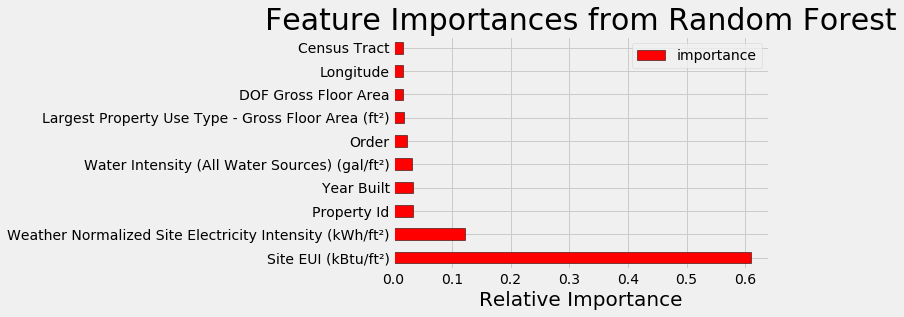

In [321]:
fig = plt.figure (figsize=(10,10))
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_importance.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'red');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Let's just use the top 6 features (see if we can build a more parsimonious model)

In [344]:
most_important=feature_importance.loc[:5,"feature"]

In [345]:
X_train_reduced = X_train[most_important]
X_test_reduced = X_test[most_important]

In [346]:
# Create the rf model with the same "best" hyperparamters
pipe_rf_reduced= Pipeline([('scl', StandardScaler()),
                    ('regr', RandomForestRegressor(min_samples_split=2,min_samples_leaf=2, n_estimators=125, max_depth=16,
                                                   random_state=42))]) # pipeline for rf

In [348]:
pipe_rf_reduced.fit(X_train_reduced, y_train)

C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [349]:
y_pred_reduced = pipe_rf_reduced.predict(X_test_reduced)

In [350]:
print("The test rmse of the best RF model (on the test set) is {}" .format(round(rmse(y_test["score"].values, y_pred_reduced),4)))
print("The test mae of the best RF model (on the test set) is {}" .format(round(mae(y_test["score"].values, y_pred_reduced),4)))

The test rmse of the best RF model (on the test set) is 16.0975
The test mae of the best RF model (on the test set) is 11.3929


The test error slightly increased, but I am now only using 6 features to predict the score rather than 18.

# Conlcusion
**Using information from 6 characteristics of a building, a random forest model was developed and it can predict the Energy Star Score of a given building to within 12 points.  The features that are most informative in the prediction are Site EUI and Weather Normalized Site Electricity Intensity.**